In [1]:
!rm -rf /kaggle/working/*

In [2]:
import os
import cv2

def extract_frames(video_path, output_dir, label):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    count = 0
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % fps == 0:  # One frame per second
            save_path = os.path.join(output_dir, f"{label}_{os.path.basename(video_path).split('.')[0]}_{frame_id}.jpg")
            cv2.imwrite(save_path, frame)
            frame_id += 1
        count += 1
    cap.release()

In [3]:
real_dir = "/kaggle/input/celeb-df-v2/Celeb-real"
fake_dir = "/kaggle/input/celeb-df-v2/Celeb-synthesis"
yt_dir = "/kaggle/input/celeb-df-v2/YouTube-real"
output_real = "/kaggle/working/frames/real"
output_fake = "/kaggle/working/frames/fake"

for video in os.listdir(real_dir):
    extract_frames(os.path.join(real_dir, video), output_real, "real")

for video in os.listdir(fake_dir):
    extract_frames(os.path.join(fake_dir, video), output_fake, "fake")

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob

# Paths
real_imgs = glob.glob("/kaggle/working/frames/real/*.jpg")
fake_imgs = glob.glob("/kaggle/working/frames/fake/*.jpg")
file_paths = real_imgs + fake_imgs
labels = [0]*len(real_imgs) + [1]*len(fake_imgs)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)


2025-05-04 12:16:25.649527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746360985.831873      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746360985.888019      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
IMG_SIZE = (299, 299)

#def load_preprocess(path, label):
#    img = tf.io.read_file(path)
#    img = tf.image.decode_jpeg(img, channels=3)
#    img = tf.image.resize(img, IMG_SIZE)
#    img = tf.keras.applications.xception.preprocess_input(img)
#    return img, label

def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    # Augmentation (only for training)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_jpeg_quality(img, 75, 100)

    img = tf.keras.applications.xception.preprocess_input(img)
    return img, label


def get_dataset(paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = get_dataset(X_train, y_train)
val_ds = get_dataset(X_val, y_val, shuffle=False)
test_ds = get_dataset(X_test, y_test, shuffle=False)

I0000 00:00:1746361017.078616      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_eer(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold_idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2
    return eer

In [15]:
from tensorflow.keras.callbacks import Callback
class EERCallback(Callback):
    def __init__(self, val_dataset):
        super(EERCallback, self).__init__()
        self.val_dataset = val_dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for batch in self.val_dataset:
            images, labels = batch
            preds = self.model.predict(images, verbose=0).ravel()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
        
        eer = self.compute_eer(np.array(y_true), np.array(y_pred))
        print(f'\nEpoch {epoch+1} — Equal Error Rate (EER): {eer:.4f}')

    def compute_eer(self, y_true, y_score):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        fnr = 1 - tpr
        eer_threshold_idx = np.nanargmin(np.abs(fnr - fpr))
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2
        return eer

In [16]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base.trainable = True  # Freeze base initially

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

eer_callback = EERCallback(val_dataset=val_ds)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 21,069,353 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    eer_callback
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
1780/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9050 - auc: 0.6423 - loss: 0.3076 - precision: 0.9104 - recall: 0.9927

E0000 00:00:1746362601.560252   25012 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746362601.757231   25012 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746362602.668278   25012 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746362602.891452   25012 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746362603.546699   25012 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9051 - auc: 0.6423 - loss: 0.3076 - precision: 0.9104 - recall: 0.9927
Epoch 1 — Equal Error Rate (EER): 0.3132
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 979s 523ms/step - accuracy: 0.9051 - auc: 0.6424 - loss: 0.3075 - precision: 0.9104 - recall: 0.9927 - val_accuracy: 0.9264 - val_auc: 0.8067 - val_loss: 0.2263 - val_precision: 0.9409 - val_recall: 0.9801
Epoch 2/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9335 - auc: 0.8221 - loss: 0.2158 - precision: 0.9360 - recall: 0.9944
Epoch 2 — Equal Error Rate (EER): 0.2775
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 897s 503ms/step - accuracy: 0.9335 - auc: 0.8221 - loss: 0.2157 - precision: 0.9360 - recall: 0.9944 - val_accuracy: 0.9411 - val_auc: 0.8494 - val_loss: 0.1902 - val_precision: 0.9463 - val_recall: 0.9910
Epoch 3/20
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9432 - auc: 0.8475 - loss: 0.1905 - precision: 0.9439 - recall: 0.9964
Epoch 3 — Equal Error Rate (EER)

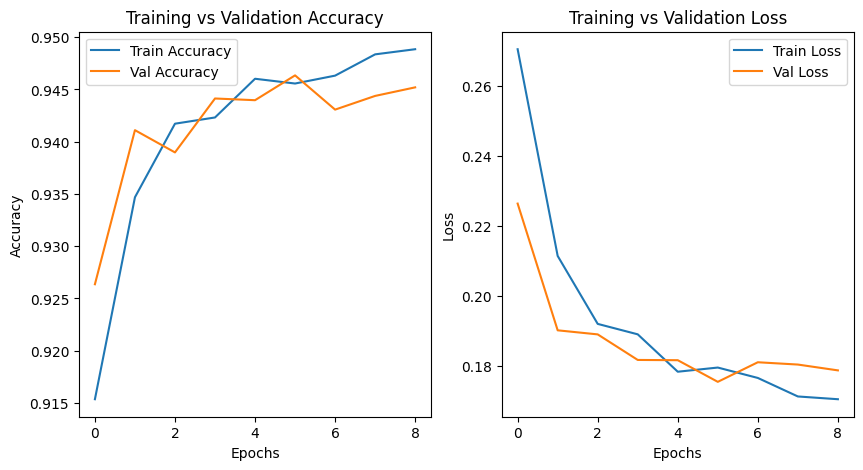

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [19]:
history.history['loss']
history.history['val_auc']
history.history['precision']

[0.9192447066307068,
 0.9370254278182983,
 0.9429385662078857,
 0.9428765773773193,
 0.9462169408798218,
 0.9454190731048584,
 0.945724606513977,
 0.9473848938941956,
 0.9477914571762085]

In [20]:
model.save("best_model_20.h5")
model.save("best_model_20.keras")

In [21]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, f1_score

y_true = np.array(y_test)
y_probs = model.predict(test_ds).ravel()
y_pred = (y_probs > 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))
print("AUC-ROC:", roc_auc_score(y_true, y_probs))
f1 = f1_score(y_true, y_pred.round())
print("F1 Score:", f1)

382/382 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step
              precision    recall  f1-score   support

        Real       0.96      0.40      0.56      1173
        Fake       0.94      1.00      0.97     11035

    accuracy                           0.94     12208
   macro avg       0.95      0.70      0.76     12208
weighted avg       0.94      0.94      0.93     12208

AUC-ROC: 0.8567588750202313
F1 Score: 0.9680112487916337


In [22]:
eer = compute_eer(y_true, y_pred)
print(f"EER Score : ", eer)

EER Score :  0.3026964888514457


In [23]:
# Remove old zip if exists
zip_path = "/kaggle/working/frames_only.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)

In [24]:
import os
import zipfile

# Define paths
source_dirs = ["/kaggle/working/frames/real", "/kaggle/working/frames/fake"]
zip_path = "/kaggle/working/frames_only.zip"

# Remove old zip if exists
if os.path.exists(zip_path):
    os.remove(zip_path)

# Create zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in source_dirs:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.join("/kaggle/working/frames"))
                zipf.write(file_path, arcname)

# Confirm zip was created
print("ZIP file created at:", zip_path)
print("File size:", os.path.getsize(zip_path), "bytes")

# Show download link
from IPython.display import FileLink
FileLink(zip_path)

ZIP file created at: /kaggle/working/frames_only.zip
File size: 4343769340 bytes


/kaggle/working/frames_only.zip